In [1]:
!pip install ctgan
!pip install sdv
!pip install sdmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.2/143.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 94.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.7/170.7 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.34
    Uninstalling botocore-1.34.34:
      Successfully uninstalled botocore-1.34.34
ERROR: pip's dependency resolver does not currently take into account all the packages that are installe

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import os
from sdv.single_table import CTGANSynthesizer
from ctgan import CTGAN

In [13]:
# 加载数据
file_path = "/kaggle/input/fraud-detection/data/A08.csv"
data = pd.read_csv(file_path)

In [14]:
# # 指定要填充的列
# columns = ["出院诊断LENTH_MAX"]

# # 将指定列的空值填0
# for column in columns:
#     data[column] = data[column].fillna(0)

# 查看原始数据集中出院诊断病种名称_NN列的NaN值个数
count_before_nan = data["出院诊断LENTH_MAX"].isnull().sum()

# 统计 出院诊断病种名称_NN 列值为 0 的个数
count_before_zero = data["出院诊断LENTH_MAX"].eq(0).sum()

# 将所有空值填0
data = data.fillna(0)

# 查看填充后数据集中出院诊断病种名称_NN列的NaN值个数
count_after_nan = data["出院诊断LENTH_MAX"].isnull().sum()

# 统计 出院诊断病种名称_NN 列值为 0 的个数
count_after_zero = data["出院诊断LENTH_MAX"].eq(0).sum()

# 打印统计结果
print("填充前：")
print("NaN值个数:", count_before_nan)
print("值为0的个数:", count_before_zero)
print("填充后：")
print("NaN值个数:", count_after_nan)
print("值为0的个数:", count_after_zero)

填充前：
NaN值个数: 355
值为0的个数: 0
填充后：
NaN值个数: 0
值为0的个数: 355


In [5]:
# 定义要提取的特征列表
features_to_extract = [
    '个人编码',
    '就诊次数_SUM',
    '药品在总金额中的占比',
    '个人支付的药品占比', 
    '检查总费用在总金额占比', 
    '治疗费用在总金额占比',
    '就诊的月数', 
    '月就诊天数_MAX', 
    '月就诊天数_AVG',
    '月就诊医院数_MAX', 
    '月就诊医院数_AVG',
    'RES'
]

# 提取特征
extracted_data = data[features_to_extract]

# 保存到新的Excel文件中
output_file_path = '/kaggle/working/fraud_trick.csv'  # 保存文件的路径和名称
extracted_data.to_csv(output_file_path, index=False)

print("文件已成功保存到", output_file_path)

文件已成功保存到 /kaggle/working/fraud_trick.csv


In [15]:
data.head()

,个人编码,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,3.521200e+14,0,6,7,5.666667,3,2.166667,34,7,5.666667,...,0.939194,0.004262,0.050817,0.0,0.007434,0.0,0,0,1,0
1,3.521200e+14,0,6,4,2.500000,2,1.333333,15,4,2.500000,...,0.955626,0.002982,0.030815,0.0,0.013398,0.0,0,0,1,0
2,3.521200e+14,8,6,8,6.166667,3,2.166667,45,9,7.500000,...,0.783610,0.000332,0.000000,0.0,0.195087,0.0,0,0,0,0
3,3.521200e+14,0,6,6,3.666667,2,1.833333,23,6,3.833333,...,0.458649,0.000184,0.000000,0.0,0.541351,0.0,0,0,0,0
4,3.521200e+14,0,6,5,4.333333,1,1.000000,26,5,4.333333,...,0.983726,0.000316,0.000000,0.0,0.016274,0.0,0,0,0,0


log_frequency：是否在条件采样中使用分类级别的对数频率。默认为 True。这个参数会影响模型处理分类值频率的方式，而这些频率会被用来作为其他值的条件。在某些情况下，将其改为 False 可能会带来更好的性能。

primary_key:设置主键

In [16]:
# CTGAN模型配置
ctgan_config = {
    "embedding_dim": 128,  # 嵌入层维度
    "generator_dim": (256, 256, 256),  # 生成器层的维度
    "discriminator_dim": (256, 256, 256),  # 判别器层的维度
    "generator_lr": 2e-4,  # 生成器学习率
    "discriminator_lr": 2e-4,  # 判别器学习率
    "batch_size": 100,  # 批量大小
    "epochs": 800  # 训练轮数
}

# 创建CTGAN模型实例
ctgan = CTGAN(**ctgan_config,verbose=True,cuda=True)

In [17]:
discrete_columns = [
    '就诊的月数',
    '医院编码_NN',
    '交易时间YYYY_NN',
    '交易时间YYYYMM_NN',
    '出院诊断病种名称_NN',
    '出院诊断LENTH_MAX',
    'BZ_民政救助',
    'BZ_城乡优抚',
    '是否挂号'
]

In [18]:
# 训练模型
ctgan.fit(data,discrete_columns)

Gen. (-1.43) | Discrim. (-0.46): 100%|██████████| 800/800 [3:12:47<00:00, 14.46s/it]  


In [19]:
# 生成合成数据
synthetic_data = ctgan.sample(
#     num_rows=1000
#     len(data)
    100000
)

# 如果需要，您可以将生成的数据保存到文件中
synthetic_data.to_csv('/kaggle/working/add_data_2.csv', index=False)

In [20]:
ctgan.save('/kaggle/working/my_ctgan_model.pkl')

In [21]:
df = pd.read_csv('/kaggle/working/add_data_2.csv')
df.head()

,个人编码,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,3.521200e+14,0,6,4,2.360182,3,2.476192,31,2,3.495471,...,0.902407,-0.002014,0.026501,0.001640,-0.004323,-0.002102,1,0,0,0
1,3.521200e+14,0,6,1,2.184774,1,1.019344,25,3,1.593298,...,0.955668,0.054282,0.002535,0.000554,-0.007590,-0.001475,0,0,1,0
2,3.521200e+14,0,6,7,5.211989,3,3.040041,20,8,3.353069,...,0.908680,0.002041,0.004957,0.000725,0.035104,0.063264,0,0,1,0
3,3.521200e+14,0,6,5,1.785932,1,0.994515,8,5,2.581181,...,0.918184,0.004130,0.014637,0.000403,0.018884,-0.001439,0,0,1,0
4,3.521200e+14,0,5,6,2.502020,3,3.357479,6,4,0.877853,...,0.790629,0.002214,0.130087,0.001900,-0.004195,0.000325,0,0,1,0


In [22]:
## 编写元数据
import json

# Update to the expected metadata format
metadata_json_corrected = {
    "primary_key": "个人编码",
    "columns": {}
}

for col in data.columns:
    if col in discrete_columns:
        metadata_json_corrected["columns"][col] = {"type": "categorical", "sdtype": "categorical"}
    else:
        metadata_json_corrected["columns"][col] = {"type": "numerical", "subtype": "float", "sdtype": "numerical"}

# Adjusting for the primary key
metadata_json_corrected["columns"]["个人编码"] = {"type": "id", "subtype": "integer", "sdtype": "id"}

# Save the corrected metadata
metadata_file_path_corrected = '/kaggle/working/A08_metadata_corrected.json'
with open(metadata_file_path_corrected, 'w') as file:
    json.dump(metadata_json_corrected, file, ensure_ascii=False, indent=4)


In [23]:
with open('/kaggle/working/A08_metadata_corrected.json') as f:
    metadata = json.load(f)

In [24]:
metadata

{'primary_key': '个人编码',
 'columns': {'个人编码': {'type': 'id', 'subtype': 'integer', 'sdtype': 'id'},
  '一天去两家医院的天数': {'type': 'numerical',
   'subtype': 'float',
   'sdtype': 'numerical'},
  '就诊的月数': {'type': 'categorical', 'sdtype': 'categorical'},
  '月就诊天数_MAX': {'type': 'numerical',
   'subtype': 'float',
   'sdtype': 'numerical'},
  '月就诊天数_AVG': {'type': 'numerical',
   'subtype': 'float',
   'sdtype': 'numerical'},
  '月就诊医院数_MAX': {'type': 'numerical',
   'subtype': 'float',
   'sdtype': 'numerical'},
  '月就诊医院数_AVG': {'type': 'numerical',
   'subtype': 'float',
   'sdtype': 'numerical'},
  '就诊次数_SUM': {'type': 'numerical', 'subtype': 'float', 'sdtype': 'numerical'},
  '月就诊次数_MAX': {'type': 'numerical',
   'subtype': 'float',
   'sdtype': 'numerical'},
  '月就诊次数_AVG': {'type': 'numerical',
   'subtype': 'float',
   'sdtype': 'numerical'},
  '月统筹金额_MAX': {'type': 'numerical',
   'subtype': 'float',
   'sdtype': 'numerical'},
  '月统筹金额_AVG': {'type': 'numerical',
   'subtype': 'float',
 

In [25]:
# 统计报告
from sdmetrics.reports.single_table import QualityReport

report = QualityReport()

report.generate(data, df, metadata,verbose=True)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 3321/3321 [03:07<00:00, 17.67it/s]

Overall Score: 79.13%

Properties:
- Column Shapes: 71.8%
- Column Pair Trends: 86.46%


In [26]:
# 诊断报告

from sdmetrics.reports.single_table import DiagnosticReport

report = DiagnosticReport()

report.generate(data, df, metadata,verbose=True)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 327.19it/s]

Overall Score: 91.68%

Properties:
- Data Validity: 83.36%
- Data Structure: 100.0%


In [27]:
# 指定需要统计的列名
column_name = 'RES'

# 统计指定列中0和1的数量
count_0 = df[column_name].eq(0).sum()
count_1 = df[column_name].eq(1).sum()

# 打印结果
print(f"在列 '{column_name}' 中，0 的数量为: {count_0}")
print(f"在列 '{column_name}' 中，1 的数量为: {count_1}")

在列 'RES' 中，0 的数量为: 92632
在列 'RES' 中，1 的数量为: 7368


## 使用随机森林模型在合成数据上训练

In [1]:
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import joblib

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns",100)
pd.set_option('display.max_rows',100)

from pylab import mpl 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 为了显示负号正常

NameError: name 'pd' is not defined

### 将合成数据集与原始数据集拼接

In [30]:
from sklearn.model_selection import train_test_split
import pandas as pd

# 原始数据集文件路径
# original_data_path = '/kaggle/working/欺诈手段特征集.xlsx'
original_data = data

# 其他文件的路径列表
other_files = ['/kaggle/working/add_data_2.csv']

# 读取原始数据集
# original_data = pd.read_excel(original_data_path)

# 将原始数据集分割为训练集和测试集
train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)

# 初始化一个空的DataFrame来存储类别为1的样本
category_1_samples = pd.DataFrame()

# 遍历其他文件
for file in other_files:
    # 读取文件
    data = pd.read_csv(file)
    
    # 提取 RES 列为1的样本
    filtered_data = data[data['RES'] == 1]
    
    # 将这些样本添加到category_1_samples
    category_1_samples = pd.concat([category_1_samples, filtered_data], ignore_index=True)

# 将提取出的样本与训练集进行拼接
combined_train_data = pd.concat([train_data, category_1_samples], ignore_index=True)

# 如果需要保存合并后的训练集和测试集
combined_train_data.to_csv('/kaggle/working/combined_train_dataset.csv', index=False)
test_data.to_csv('/kaggle/working/test_dataset.csv', index=False)


In [32]:
data = pd.read_csv('/kaggle/working/combined_train_dataset.csv')
test = pd.read_csv('/kaggle/working/test_dataset.csv')

# 删除个人编码特征列
data = data.drop(['个人编码'], axis=1)
test = test.drop(['个人编码'], axis=1)
data.shape,test.shape

((18568, 81), (4800, 81))

In [50]:
# 计算类别1的样本数
count_class_1 = data[data["RES"] == 1].shape[0]
count_class_0 = data[data["RES"] == 0].shape[0]

# 打印类别1的样本数
print("类别1的样本数：", count_class_1)
print("类别0的样本数：", count_class_0)

类别1的样本数： 7924
类别0的样本数： 10644


In [33]:
def strategy_4(model, X_test, y_test, thresholds):

    classification_reports = {}
    for thresh in thresholds:
        # 以概率形式获取预测结果
        y_probs = model.predict_proba(X_test)[:, 1]  # 获取正类的概率
        # 应用阈值
        y_pred_thresh = np.where(y_probs > thresh, 1, 0)
        # 生成并存储分类报告
        classification_reports[thresh] = classification_report(y_test, y_pred_thresh)

    return classification_reports

In [34]:
# 分离特征和目标变量
X = data.drop('RES', axis=1)
y = data['RES']

# 分离类别
data_majority = data[data.RES == 0]
data_minority = data[data.RES == 1]

X.shape

(18568, 80)

In [35]:
model = RandomForestClassifier(
    n_estimators=100,
    #max_depth=5,
    random_state=123,
    n_jobs=-1
)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

X_train.shape

(12997, 80)

In [42]:
model = model.fit(X,y)

In [43]:
# 分离特征和目标变量
X_test = test.drop('RES', axis=1)
y_test = test['RES']

In [44]:
thresholds = [ 0.5,0.55, 0.6,0.65, 0.7,0.75]
reports = strategy_4(model,X_test, y_test, thresholds)

# 输出每个阈值下的分类报告
for thresh, report in reports.items():
    print(f"Threshold: {thresh}\n", report)

Threshold: 0.5
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      4563
           1       0.79      0.34      0.47       237

    accuracy                           0.96      4800
   macro avg       0.88      0.67      0.73      4800
weighted avg       0.96      0.96      0.96      4800

Threshold: 0.55
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      4563
           1       0.83      0.33      0.47       237

    accuracy                           0.96      4800
   macro avg       0.90      0.66      0.73      4800
weighted avg       0.96      0.96      0.96      4800

Threshold: 0.6
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4563
           1       0.88      0.30      0.45       237

    accuracy                           0.96      4800
   macro avg       0.92      0.65      0.71      4800
weighted avg       0.96  

In [45]:
thresholds = [0.6]
reports = strategy_4(model,X_test, y_test,thresholds)
report

'              precision    recall  f1-score   support\n\n           0       0.96      1.00      0.98      4563\n           1       0.96      0.20      0.33       237\n\n    accuracy                           0.96      4800\n   macro avg       0.96      0.60      0.66      4800\nweighted avg       0.96      0.96      0.95      4800\n'

In [46]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 计算AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

AUC: 0.9043517339525129


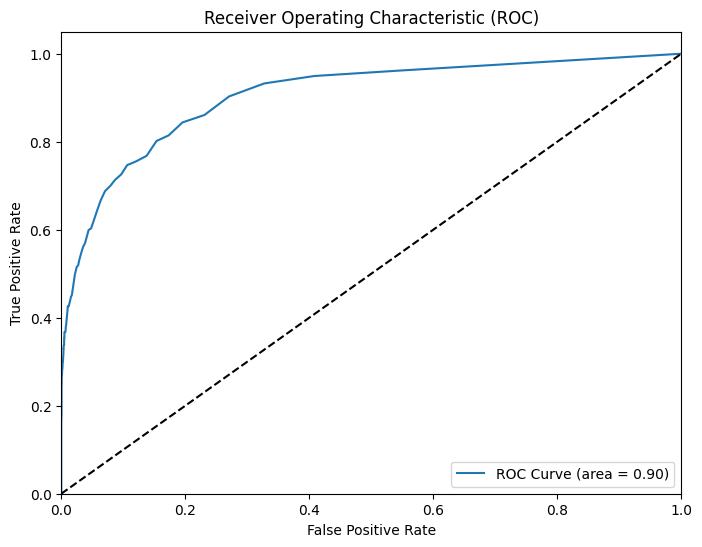

In [47]:
# 获取真正率（TPR）和假正率（FPR）以及阈值用于绘制ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # 随机概率的对角线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [48]:
# 获取特征重要性
feature_importances = model.feature_importances_

# 排序特征重要性
sorted_idx = np.argsort(feature_importances)[::-1]

# 取出前二十个重要特征
top_20_features = np.array(X_train.columns)[sorted_idx][:20]

top_20_features

array(['其它发生金额_SUM', '医疗救助个人按比例负担金额_SUM', '残疾军人补助_SUM', '检查费自费金额_SUM',
       '个人支付治疗费用占比', '公务员医疗补助基金支付金额_SUM', '手术费申报金额_SUM', '城乡优抚补助_SUM',
       '高价材料发生金额_SUM', '贵重检查费金额_SUM', '起付线标准金额_MAX', '最高限额以上金额_SUM',
       '床位费申报金额_SUM', '医疗救助医院申请_SUM', '成分输血申报金额_SUM', '民政救助补助_SUM',
       '个人支付检查费用占比', '城乡救助补助金额_SUM', '治疗费自费金额_SUM', '月药品金额_MAX'],
      dtype=object)